# 模組 3.2: 缺失值插補方法 (Imputation Methods)

## 學習目標
- 理解插補 (Imputation) 的基本概念及其相對於刪除法的優勢。
- 學習並實作常見的單變數插補方法：均值、中位數、眾數和常數填充。
- 了解並應用更進階的多變數插補方法，如 K-近鄰 (KNN) 插補。
- 能夠根據特徵的類型和分佈，選擇合適的插補策略。

## 導論：什麼是插補？

在上一個筆記本中，我們了解到刪除缺失值會損失寶貴的數據。**插補 (Imputation)** 是一種用 **估計值** 來替換缺失值的策略，旨在保留資料集的完整性。

您的指南中提到：「*均值/中位數填充...可能扭曲變數的方差和相關性*」，而進階方法「*更複雜，但可能更準確*」。這揭示了插補的核心權衡：**方法的複雜度** vs. **對原始數據分佈的影響**。本筆記本將帶您探索從簡單到相對複雜的各種插補技術。

In [47]:
# 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer

# 設定視覺化風格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
print("Libraries and styles configured.")

# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')






Libraries and styles configured.


| #／序號 | Column／欄位名稱                                    | Non-Null Count／非空值數量          | Dtype／資料型別        |
|:------:|:----------------------------------------------------|:-----------------------------------|:----------------------|
| 0      | Id<br>編號                                          | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 1      | MSSubClass<br>建築類別                              | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 2      | MSZoning<br>分區 (Zoning)                           | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 3      | LotFrontage<br>街區路段寬度                         | 1201 non-null<br>1201 非空值       | float64<br>浮點數     |
| 4      | LotArea<br>地段面積                                 | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 5      | Street<br>街道類型                                  | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 6      | Alley<br>巷道類型                                   | 91 non-null<br>91 非空值           | object<br>字串        |
| 7      | LotShape<br>地塊形狀                                | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 8      | LandContour<br>地形輪廓                             | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 9      | Utilities<br>公用設施                               | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 10     | LotConfig<br>地塊配置                               | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 11     | LandSlope<br>地面坡度                               | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 12     | Neighborhood<br>社區/街區                           | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 13     | Condition1<br>鄰近主要道路/鐵路                     | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 14     | Condition2<br>鄰近次要道路/鐵路                     | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 15     | BldgType<br>建築類型                                | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 16     | HouseStyle<br>房屋風格                              | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 17     | OverallQual<br>整體品質                            | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 18     | OverallCond<br>整體狀況                            | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 19     | YearBuilt<br>建造年份                              | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 20     | YearRemodAdd<br>重建/翻新年份                       | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 21     | RoofStyle<br>屋頂風格                               | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 22     | RoofMatl<br>屋頂材料                                | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 23     | Exterior1st<br>外牆第一層材料                       | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 24     | Exterior2nd<br>外牆第二層材料                       | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 25     | MasVnrType<br>砌體飾面類型                         | 588 non-null<br>588 非空值         | object<br>字串        |
| 26     | MasVnrArea<br>砌體飾面面積                         | 1452 non-null<br>1452 非空值       | float64<br>浮點數     |
| 27     | ExterQual<br>外牆品質                              | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 28     | ExterCond<br>外牆狀況                              | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 29     | Foundation<br>地基類型                             | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 30     | BsmtQual<br>地下室高度品質                         | 1423 non-null<br>1423 非空值       | object<br>字串        |
| 31     | BsmtCond<br>地下室狀況                             | 1423 non-null<br>1423 非空值       | object<br>字串        |
| 32     | BsmtExposure<br>地下室採光情況                     | 1422 non-null<br>1422 非空值       | object<br>字串        |
| 33     | BsmtFinType1<br>地下室裝修類型1                    | 1423 non-null<br>1423 非空值       | object<br>字串        |
| 34     | BsmtFinSF1<br>地下室裝修面積1                      | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 35     | BsmtFinType2<br>地下室裝修類型2                    | 1422 non-null<br>1422 非空值       | object<br>字串        |
| 36     | BsmtFinSF2<br>地下室裝修面積2                      | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 37     | BsmtUnfSF<br>地下室未裝修面積                      | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 38     | TotalBsmtSF<br>地下室總面積                        | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 39     | Heating<br>供暖種類                                | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 40     | HeatingQC<br>供暖品質                              | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 41     | CentralAir<br>中央冷氣                             | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 42     | Electrical<br>電氣系統                             | 1459 non-null<br>1459 非空值       | object<br>字串        |
| 43     | 1stFlrSF<br>一樓面積                               | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 44     | 2ndFlrSF<br>二樓面積                               | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 45     | LowQualFinSF<br>低品質裝修面積                     | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 46     | GrLivArea<br>地上居住面積                          | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 47     | BsmtFullBath<br>地下室完整衛浴數                   | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 48     | BsmtHalfBath<br>地下室半衛浴數                     | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 49     | FullBath<br>完整衛浴數                             | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 50     | HalfBath<br>半衛浴數                               | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 51     | BedroomAbvGr<br>地上臥室數                         | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 52     | KitchenAbvGr<br>地上廚房數                         | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 53     | KitchenQual<br>廚房品質                            | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 54     | TotRmsAbvGrd<br>地上總房間數 (不含衛浴)            | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 55     | Functional<br>功能性評分                           | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 56     | Fireplaces<br>壁爐數                               | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 57     | FireplaceQu<br>壁爐品質                            | 770 non-null<br>770 非空值         | object<br>字串        |
| 58     | GarageType<br>車庫類型                             | 1379 non-null<br>1379 非空值       | object<br>字串        |
| 59     | GarageYrBlt<br>車庫建造年份                        | 1379 non-null<br>1379 非空值       | float64<br>浮點數     |
| 60     | GarageFinish<br>車庫完工情況                       | 1379 non-null<br>1379 非空值       | object<br>字串        |
| 61     | GarageCars<br>車庫停車位數                         | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 62     | GarageArea<br>車庫面積                             | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 63     | GarageQual<br>車庫品質                             | 1379 non-null<br>1379 非空值       | object<br>字串        |
| 64     | GarageCond<br>車庫狀況                             | 1379 non-null<br>1379 非空值       | object<br>字串        |
| 65     | PavedDrive<br>鋪裝車道                            | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 66     | WoodDeckSF<br>木質甲板面積                         | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 67     | OpenPorchSF<br>開放式門廊面積                      | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 68     | EnclosedPorch<br>封閉式門廊面積                    | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 69     | 3SsnPorch<br>三季門廊面積                         | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 70     | ScreenPorch<br>有紗窗的門廊面積                    | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 71     | PoolArea<br>泳池面積                               | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 72     | PoolQC<br>泳池品質                                 | 7 non-null<br>7 非空值             | object<br>字串        |
| 73     | Fence<br>圍欄品質                                  | 281 non-null<br>281 非空值         | object<br>字串        |
| 74     | MiscFeature<br>其他特色                            | 54 non-null<br>54 非空值           | object<br>字串        |
| 75     | MiscVal<br>其他價值                                | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 76     | MoSold<br>銷售月份                                 | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 77     | YrSold<br>銷售年份                                 | 1460 non-null<br>1460 非空值       | int64<br>整數         |
| 78     | SaleType<br>銷售類型                               | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 79     | SaleCondition<br>銷售狀況                          | 1460 non-null<br>1460 非空值       | object<br>字串        |
| 80     | SalePrice<br>銷售價格                              | 1460 non-null<br>1460 非空值       | int64<br>整數         |


## 1. 準備資料

我們再次使用 House Prices 資料集，並專注於幾個有代表性缺失值的欄位。

In [48]:
# 載入資料
# path = 'data_mining_course/datasets/raw/house_prices/train.csv'
path = r'..\..\..\..\datasets\raw\house_prices\train.csv'
try:
    df = pd.read_csv(path)
    # 為了演示，我們只選取一部分欄位
    cols_to_use = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'FireplaceQu', 'SalePrice']
    df_subset = df[cols_to_use].copy()
    print("成功載入並選取資料子集!")
    df_subset.info()
except FileNotFoundError:
    print(f"在 '{path}' 找不到 train.csv。")
    df_subset = pd.DataFrame() # 建立空 DataFrame 以免後續出錯



成功載入並選取資料子集!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrArea   1452 non-null   float64
 2   GarageYrBlt  1379 non-null   float64
 3   FireplaceQu  770 non-null    object 
 4   SalePrice    1460 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 57.2+ KB


## 2. 單變數插補 (Univariate Imputation)

單變數插補僅使用特徵自身的值來推斷缺失值，不考慮其他特徵。

### 2.1 均值/中位數/眾數填充

這是最簡單的統計插補方法。
- **均值 (Mean)**: 適用於分佈較對稱的數值型特徵。
- **中位數 (Median)**: 當數值型特徵存在偏態或異常值時，中位數比均值更穩健。
- **眾數 (Most Frequent / Mode)**: 適用於類別型特徵。

Scikit-learn 的 `SimpleImputer` 是一個方便的工具。

In [49]:
df_subset[['FireplaceQu']].isnull()

,FireplaceQu
0,True
1,False
2,False
3,False
4,False
...,...
1455,False
1456,False
1457,False
1458,True


In [50]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrArea   1452 non-null   float64
 2   GarageYrBlt  1379 non-null   float64
 3   FireplaceQu  770 non-null    object 
 4   SalePrice    1460 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 57.2+ KB


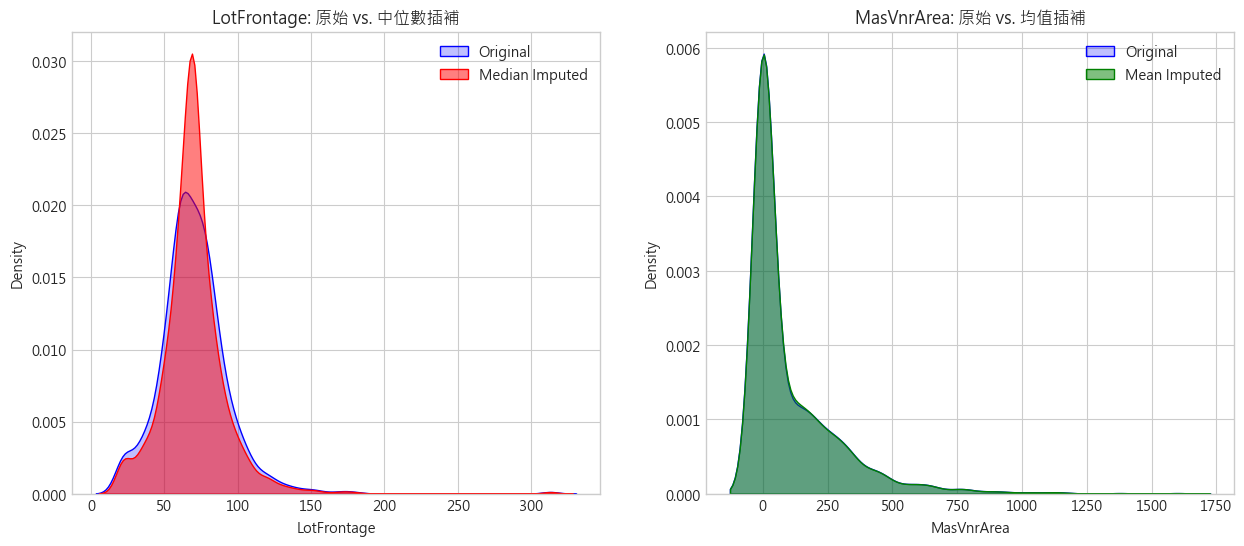

In [51]:
# --- 中位數填充 LotFrontage (因為它可能有偏態) ---
median_imputer = SimpleImputer(strategy='median')
# SimpleImputer 需要 2D 陣列, 所以我們用 [[]]
df_subset['LotFrontage_median'] = median_imputer.fit_transform(df_subset[['LotFrontage']])

# --- 均值填充 MasVnrArea ---
mean_imputer = SimpleImputer(strategy='mean')
df_subset['MasVnrArea_mean'] = mean_imputer.fit_transform(df_subset[['MasVnrArea']])

# --- 眾數填充 FireplaceQu ---
mode_imputer = SimpleImputer(strategy='most_frequent')
df_subset['FireplaceQu_mode'] = mode_imputer.fit_transform(df_subset[['FireplaceQu']]).ravel()


# 視覺化比較原始分佈與插補後的分佈
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.kdeplot(df_subset['LotFrontage'].dropna(), ax=axes[0], label='Original', color='blue', fill=True)
sns.kdeplot(df_subset['LotFrontage_median'], ax=axes[0], label='Median Imputed', color='red', fill=True, alpha=0.5)
axes[0].set_title('LotFrontage: 原始 vs. 中位數插補')
axes[0].legend()

sns.kdeplot(df_subset['MasVnrArea'].dropna(), ax=axes[1], label='Original', color='blue', fill=True)
sns.kdeplot(df_subset['MasVnrArea_mean'], ax=axes[1], label='Mean Imputed', color='green', fill=True, alpha=0.5)
axes[1].set_title('MasVnrArea: 原始 vs. 均值插補')
axes[1].legend()
plt.show()



**觀察**:
從 `LotFrontage` 的圖中可以看到，使用單一值（中位數）填充會導致分佈在該值處出現一個尖峰，這會 **扭曲原始數據的分佈並低估變異數**。這就是簡單統計插補法的主要缺點。

### 2.2 常數填充

當缺失值具有特定含義時（如我們之前判斷的 MNAR），使用常數填充是最佳選擇。

In [53]:
# 對於 FireplaceQu (壁爐品質)，缺失代表 "沒有壁爐"
# 我們可以用 "None" 這個字串來填充
const_imputer = SimpleImputer(strategy='constant', fill_value='None')
df_subset['FireplaceQu_const'] = const_imputer.fit_transform(df_subset[['FireplaceQu']]).ravel()

print("使用 'None' 填充 FireplaceQu 後的值計數:")
print(df_subset['FireplaceQu_const'].value_counts())



使用 'None' 填充 FireplaceQu 後的值計數:
FireplaceQu_const
None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: count, dtype: int64


## 3. 多變數插補 (Multivariate Imputation)

多變數插補利用其他特徵的資訊來推斷缺失值，通常比單變數方法更精確。

### K-近鄰 (KNN) 插補

KNNImputer 的原理是：對於一個含有缺失值的樣本，它會在資料集中尋找與該樣本最相似（距離最近）的 K 個鄰居，然後用這 K 個鄰居在該特徵上的加權平均值（或眾數）來填充缺失值。

In [54]:
# 為了使用 KNN，我們需要所有特徵都是數值型的
# 這裡我們只選取幾個數值特徵做示範
knn_df = df[['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice']].copy()

# 初始化 KNNImputer，例如尋找 5 個鄰居
knn_imputer = KNNImputer(n_neighbors=5)

# 進行插補
knn_imputed_data = knn_imputer.fit_transform(knn_df)

# 將結果轉回 DataFrame
df_knn_imputed = pd.DataFrame(knn_imputed_data, columns=knn_df.columns)

print("KNN 插補前的缺失值數量:")
print(knn_df.isnull().sum())
print("\nKNN 插補後的缺失值數量:")
print(df_knn_imputed.isnull().sum())



KNN 插補前的缺失值數量:
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
SalePrice        0
dtype: int64

KNN 插補後的缺失值數量:
LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
SalePrice      0
dtype: int64


**視覺化比較**
讓我們再次比較 `LotFrontage` 的分佈，看看 KNN 插補是否比中位數插補更能維持原始分佈。

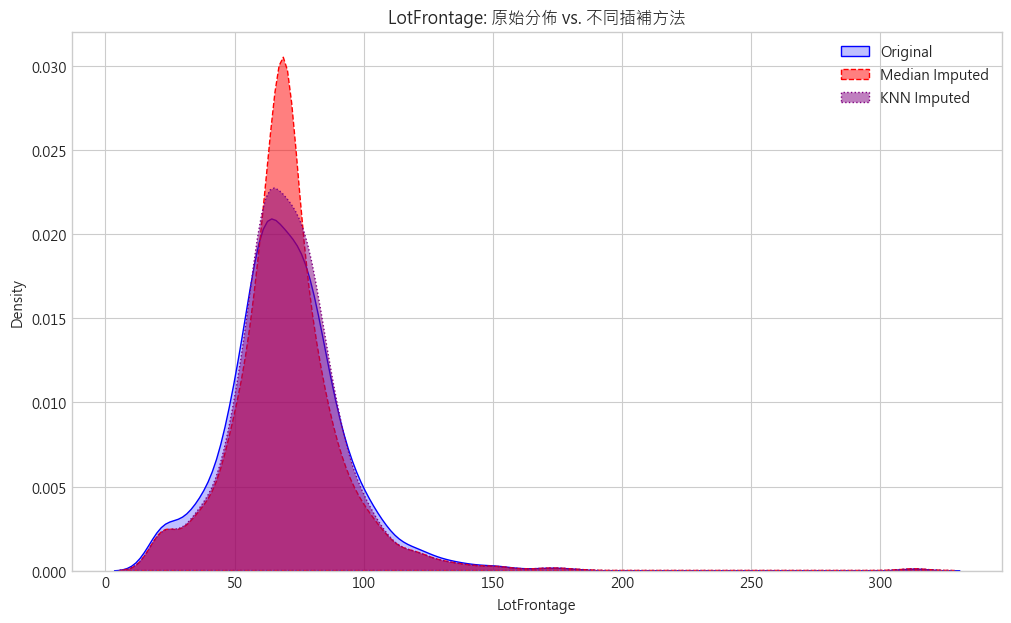

In [55]:
plt.figure(figsize=(12, 7))
sns.kdeplot(knn_df['LotFrontage'].dropna(), label='Original', color='blue', fill=True)
sns.kdeplot(df_subset['LotFrontage_median'], label='Median Imputed', color='red', linestyle='--', fill=True, alpha=0.5)
sns.kdeplot(df_knn_imputed['LotFrontage'], label='KNN Imputed', color='purple', linestyle=':', fill=True, alpha=0.5)
plt.title('LotFrontage: 原始分佈 vs. 不同插補方法')
plt.legend()
plt.show()



**觀察**:
- 中位數插補（紅色虛線）在分佈中產生了一個明顯的尖峰。
- KNN 插補（紫色點線）生成的分佈更接近原始分佈（藍色實線），它沒有在某個單一值上產生尖峰，而是根據鄰近樣本生成了更多樣化的填充值。這表明 KNN 在維持資料原始結構方面通常優於簡單的統計插補。

## 總結

在這個筆記本中，我們探討了多種缺失值插補方法：

| 方法類型 | 具體技術 | 優點 | 缺點 | 適用場景 |
| :--- | :--- | :--- | :--- | :--- |
| **單變數** | **均值/中位數/眾數** | 簡單、快速、易於實現。 | 扭曲原始數據分佈，低估變異數，破壞特徵間的相關性。 | 快速原型開發，或缺失比例極低時。 |
| **單變數** | **常數填充** | 能保留「缺失即資訊」的模式。 | 需要明確的業務邏輯支持。 | 當缺失為 MNAR 且有明確含義時（如 "無"）。 |
| **多變數** | **K-近鄰 (KNN)** | 利用特徵間關係，通常比單變數方法更準確，更能維持數據分佈。 | 計算成本較高，對異常值敏感，需要所有特徵為數值。 | 當特徵間存在相關性，且希望得到更精確的插補結果時。 |

選擇哪種插補方法取決於資料的特性、缺失的比例和模式，以及你對模型性能和計算成本的權衡。沒有一種方法是萬能的，通常需要實驗和比較。